<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/Data_curation%2Bsplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to our Data curation file. Find here the work to Connected Assays and Minimal Data curation. Execute the cells unless noted otherwise.

In [1]:
!pip install rdkit # Order of installment was important now it should work
!pip install scikit-learn

In [2]:
#Import packages

import pandas as pd
import re
import numpy as np
import os
from google.colab import drive
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
RDLogger.DisableLog("rdApp.info")

from rdkit.Chem import Descriptors, rdMolDescriptors

In [3]:
#RUN THIS CELL IF func.py CHANGES

#get functions from functions file (still have to move most of the functions there!)
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/df_dpph.csv

#from func import is_substruct_in, convert_smiles_series_to_fp_to_np_array, convert_smiles_series_to_fp_to_np_array_exception_handling
#why import functions one by one?
#could be executed alternatively by:
%run func.py

--2025-06-26 15:27:01--  https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py [following]
--2025-06-26 15:27:02--  https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6467 (6.3K) [text/plain]
Saving to: ‘func.py’

func.py             100%[===================>]   6.32K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-06-26 15:27:02 (47.6 MB/s) - ‘func.py’ sav

#Data curation
*   Landrum data curation (connected assays with network)
*   Minimal data curation

##Landrum et al. inspired data curation (10.1021/acs.jcim.4c00049)

In [4]:
#Read in the csv
df_dpph = pd.read_csv('df_dpph.csv')

In [5]:
import networkx as nx

def extract_connected_assays(df):
    """
    Extracts rows from the input dataframe (df_dpph) that have operator '='
    and belong to canonical_Smiles groups for which the compound was measured
    in at least two different assays (Assay Description) with pIC50 values that
    are in close agreement (absolute difference less than 0.3).

    Parameters:
      df (pd.DataFrame): Input dataframe with the following columns:
                         'operator', 'canonical_Smiles', 'pIC50',
                         'Assay Description', and 'DOI'.

    Returns:
      pd.DataFrame: A filtered dataframe containing only those rows from
                    assays that are connected via compatible pIC50 measurements.
    """
    # Work only on the rows where the operator is "=".
    df_eq = df[df['operator'] == '='].copy()
    connected_assays = set()
    # Use a set to gather indices of rows meeting the connection criterion.
    excluded_assays = set()
    rows_to_drop = set()


    assay_1 = []
    assay_2 = []
    Graph = nx.Graph()

    # Group the data by canonical_Smiles.
    for smile, group in df_eq.groupby('canonical_Smiles'):    #return value of groupby() is a single value (here a string) and a dataframe

        # Only consider groups measured in at least two different assay descriptions.
        assay_descs = group['Assay Description'].unique()
        if len(assay_descs) < 2:
            continue

        # Flag to check if at least one pair of rows (from different assays) meets the criterion.
        found_connection = False
        group_indices = group.index.tolist()
        if len(group_indices) < 2:
          break
        # Compare every unique pair from the group.
        for i in range(len(group_indices)):

            for j in range(i + 1, len(group_indices)):
                row_i = group.loc[group_indices[i]]
                row_j = group.loc[group_indices[j]]

                # Only consider pairs coming from different assay descriptions.
                if row_i['Assay Description'] != row_j['Assay Description']:
                  if row_i['DOI'] == row_j['DOI']: #if assays are from the same doi skip the loop
                    continue
                  if row_i["pIC50"]==row_j["pIC50"]:
                    rows_to_drop.update([row_i.name])
                    rows_to_drop.update([row_j.name])
                  if row_i["canonical_Smiles"] == row_j["canonical_Smiles"]:
                    diff = abs(row_i['pIC50'] - row_j['pIC50'])
                    #if diff > 3:  #including breaking conditon where assays differ by power of 3, yeah not really a good Idea in hindsight is removed
                      #break
                    if diff < 0.3:
                        #connected_indices.add(group_indices[i])
                        #connected_indices.add(group_indices[j])
                        edge_1 = row_i["Assay Description"]
                        edge_2 = row_j["Assay Description"]
                        Graph.add_edge(edge_1, edge_2)

    for edge in nx.connected_components(Graph):
      if len(edge) > 1: #only get assays which are connected to more than 1 other assay
          connected_assays.update(edge)
    largest_cc = max(nx.connected_components(Graph), key=len) #only return the largest graph not a small subgraph
    connected_assays.update(largest_cc)

    df_eq.drop(index=rows_to_drop, inplace=True)


    #connected_assays = [node for node, degree in Graph.degree() if degree > 2]
    # Return the subset of rows that are connected.
    return df_eq.loc[df_eq["Assay Description"].isin(connected_assays)].reset_index(drop=True), assay_1, assay_2, Graph


connected_df, assay_1, assay_2, Graph = extract_connected_assays(df_dpph)



/tmp/ipython-input-6-2555220554.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


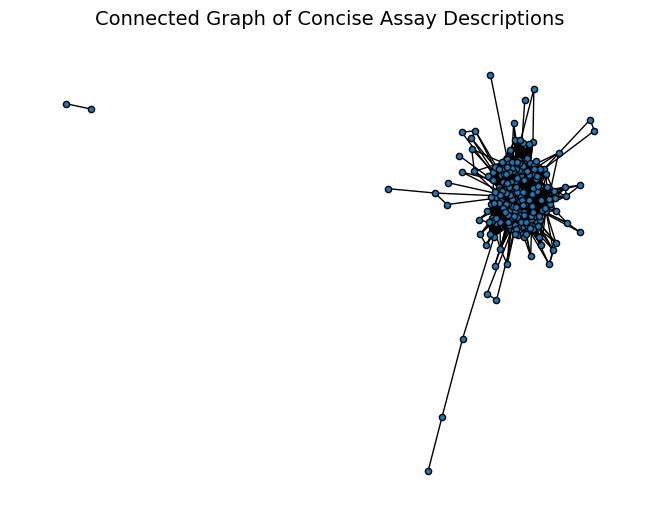

Final curated DataFrame has 3267 unique canonical_Smiles and 217 unique assay descriptions.


In [6]:
# Now, connected_df contains all rows from assays that are connected
# via a canonical smile measured in at least two different assays with |ΔpIC50| < 0.3.
nx.draw_spring(Graph, with_labels=False, node_size=20, edgecolors='black')
# nx.draw_networkx_nodes(Graph, node_color='skyblue', node_size=800, edgecolors='black')
# nx.draw_networkx_edges(Graph, width=2, alpha=0.6)
# nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

# Add title
plt.title("Connected Graph of Concise Assay Descriptions", fontsize=14)

# Remove axes
plt.axis('off')
plt.tight_layout()
plt.show()
plt.show()


# Now, report the number of unique canonical smiles and assay descriptions in the final dataframe.
num_smiles = connected_df['canonical_Smiles'].nunique()
num_assays = connected_df['Assay Description'].nunique()
print(f"Final curated DataFrame has {num_smiles} unique canonical_Smiles and {num_assays} unique assay descriptions.")

#connected_df
# connected_df was manually saved once to github

In [7]:
#check how many are phenolic
connected_df['Assay Description'].value_counts()
connected_df_unique_smiles = connected_df[["SMILES", "is_phenol"]].drop_duplicates().reset_index(drop=True)
phenolic_compounds = len(connected_df_unique_smiles[connected_df_unique_smiles['is_phenol'] == 1])

print(f"Phenolic compounds: {phenolic_compounds} left of total {len(connected_df_unique_smiles)}")

Phenolic compounds: 1954 left of total 3267


In [8]:
#Removal of duplicate canonical smiles
connected_df_grouped = (
    connected_df
    .groupby('canonical_Smiles')
    .agg(
        pIC50_mean=('pIC50', 'mean'),
        pIC50_median=('pIC50', 'median'),
        pIC50_var=('pIC50', 'var'),
        is_phenol=('is_phenol', 'first')  # Keep first occurrence (all duplicates are identical)
    )
    .reset_index()  # Flatten the index
)

print(f"Length of dataframe after removing duplicates: ", len(connected_df_grouped))

Length of dataframe after removing duplicates:  3267


Text(0, 0.5, 'assay_2 [pIC50]')

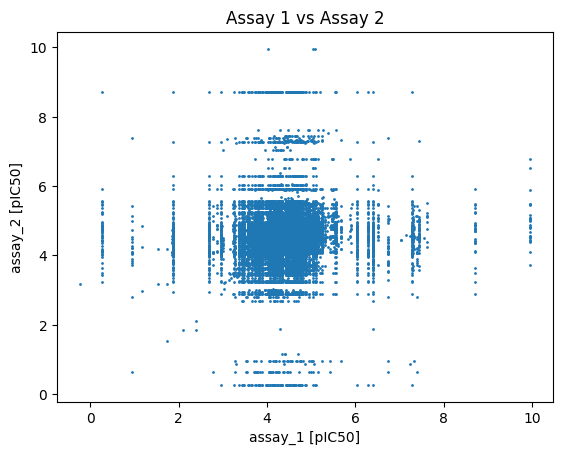

In [9]:
assay_1 = []
assay_2 = []

for smiles, group in connected_df.groupby("canonical_Smiles"):
  group_indices = group.index.tolist()

  n = len(group_indices)


  for i in range(len(group_indices)):
        for j in range(i + 1, len(group_indices)):  # avoid self-pairs and duplicates
          row_i = connected_df.loc[group_indices[i]]
          row_j = connected_df.loc[group_indices[j]]
          if row_j['Assay Description'] != row_i['Assay Description']:
            #if np.abs(row_i["pIC50"] - row_j["pIC50"]) :
            assay_1.append(row_i['pIC50'])
            assay_2.append(row_j['pIC50'])


#print(assay_1)
plt.scatter(assay_1, assay_2, s=1)
plt.title("Assay 1 vs Assay 2")
plt.xlabel("assay_1 [pIC50]")
plt.ylabel("assay_2 [pIC50]")

In [10]:
outliers = connected_df[connected_df["pIC50"] < 2]
print(f"Number of outliers: {len(outliers['pIC50'])}")
variance = connected_df_grouped[('pIC50_var')].median()
print(f"Median variance of the pIC50 values: {variance}")

print(f"number of compounds with multiple values (i.e valid variance) which passed the connection test: {len(connected_df_grouped[('pIC50_var')].dropna())}")

Number of outliers: 162
Median variance of the pIC50 values: 0.058168379887412816
number of compounds with multiple values (i.e valid variance) which passed the connection test: 136


number of smiles which have a variance (i.e values which exist more than once): 136


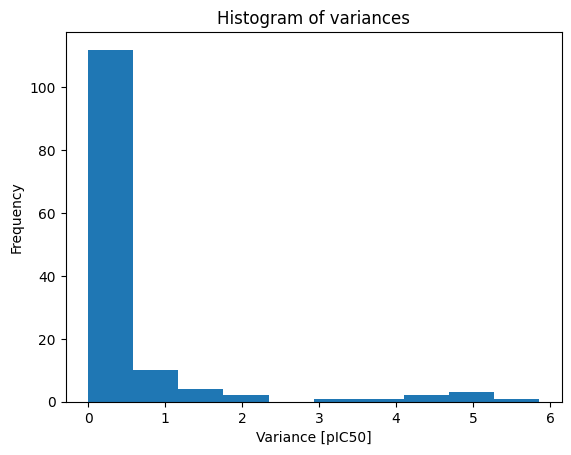

,index,pIC50_var
0,155,0.000001
1,225,0.036764
2,235,0.013424
3,293,0.251987
4,294,0.000003
...,...,...
131,3196,0.105737
132,3199,0.001855
133,3201,0.455289
134,3209,0.020167


In [11]:
connected_df_grouped_with_multiple_values = connected_df_grouped[('pIC50_var')].dropna().reset_index()

valid_variances = connected_df_grouped_with_multiple_values[('pIC50_var')] #getting the variances which are not none and why are not of values with only
print(f"number of smiles which have a variance (i.e values which exist more than once): {len(valid_variances)}")
plt.hist(valid_variances)
plt.title("Histogram of variances")
plt.xlabel("Variance [pIC50]")
plt.ylabel("Frequency")
plt.show()

connected_df_grouped_with_multiple_values#.columns



## Processing df from landrum data curation
* remove duplicates by taking grouped smiles and define pIC50_median as pIC50 value
* some processing
* generate activity column based on chosen threshold

In [12]:
# Step 2: Drop rows with missing canonical_Smiles
df_process = connected_df_grouped.dropna(subset=["canonical_Smiles"])

# Step 3: Keep only canonical_Smiles and pIC50_median and is_phenol
df_process = df_process[["canonical_Smiles", "pIC50_median", "is_phenol"]].copy()

# Step 4: Rename pIC50_median to pIC50 for ML simplicity
df_process = df_process.rename(columns={"pIC50_median": "pIC50"})

# Step 5: Drop duplicates based on SMILES
df_process = df_process.drop_duplicates(subset="canonical_Smiles", keep="first")

#create is_phenolic
phenol = "cccccc[OH]"
df_process["is_phenol"] = df_process.apply(lambda x: is_substruct_in(mol_smiles=x["canonical_Smiles"], substruct_smarts=phenol), axis=1)

# Step 6: Ensure pIC50 is numeric
df_process["pIC50"] = pd.to_numeric(df_process["pIC50"], errors="coerce")


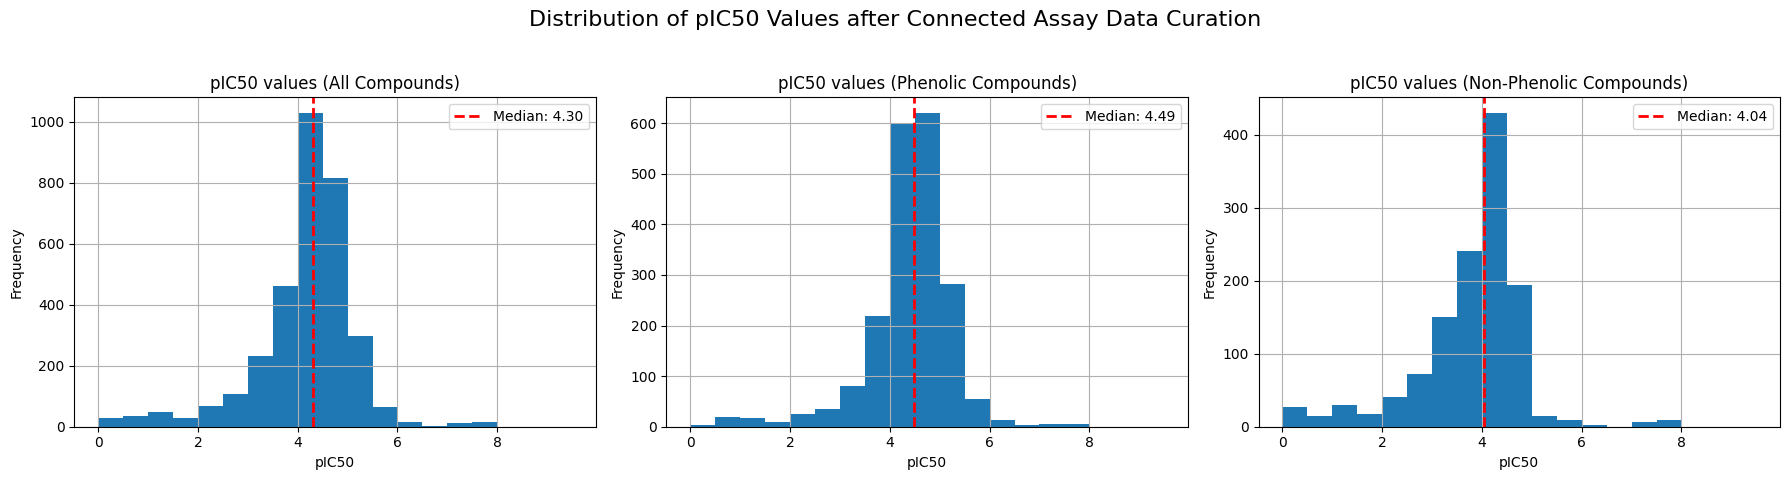

,canonical_Smiles,pIC50,is_phenol
6,C/C(=C/O[C@@H]1O[C@H](COC(=O)c2cc(O)c(O)c(O)c2...,4.502131,1
7,C/C(=C\c1c(C)c(O)cc2c1[nH]c1c(O)ccc(C=O)c12)CC...,5.148742,1
8,C/C(=C\c1c(C)c(O)cc2c1[nH]c1c(O)ccc(CO)c12)CCC...,5.004365,1
9,C/C(=N/NC(=O)c1cc2ccc(O)cc2oc1=N)c1nc(-c2ccccc...,0.603577,1
30,C/C=C(/C)C(=O)OCc1c(C(C)=O)c(O)c(OC)c2c1[C@@H]...,3.698970,1
...,...,...,...
3247,[O-][S+](/C=C/c1ccc(O)c(O)c1)CCCc1ccccc1,4.841638,1
3248,[O-][S+](/C=C/c1ccc(O)c(O)c1)CCc1ccccc1,4.935542,1
3249,[O-][S+](/C=C/c1ccc(O)c(O)c1)Cc1ccc(C(F)(F)F)cc1,5.107905,1
3250,[O-][S+](/C=C/c1ccc(O)c(O)c1)Cc1ccc(Cl)cc1,5.091515,1


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot for all compounds
median_all = df_process["pIC50"].median()
binsize = 0.5
bins = np.arange(0, 10, binsize)
axes[0].hist(df_process['pIC50'], bins=bins)
axes[0].axvline(x = median_all, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median_all:.2f}")
axes[0].set_xlabel("pIC50")
axes[0].set_ylabel("Frequency")
axes[0].set_title("pIC50 values (All Compounds)")
axes[0].legend()
axes[0].grid()

# Plot for phenolic compounds
df_is_phenol = df_process[df_process["is_phenol"] == 1]
median_phenol = df_is_phenol["pIC50"].median()
axes[1].hist(df_is_phenol["pIC50"], bins=bins)
axes[1].axvline(x = median_phenol, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median_phenol:.2f}")
axes[1].set_xlabel("pIC50")
axes[1].set_ylabel("Frequency")
axes[1].set_title("pIC50 values (Phenolic Compounds)")
axes[1].legend()
axes[1].grid()

# Plot for non-phenolic compounds
df_is_not_phenol = df_process[df_process["is_phenol"] == 0]
median_not_phenol = df_is_not_phenol["pIC50"].median()
axes[2].hist(df_is_not_phenol["pIC50"], bins=bins)
axes[2].axvline(x = median_not_phenol, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median_not_phenol:.2f}")
axes[2].set_xlabel("pIC50")
axes[2].set_ylabel("Frequency")
axes[2].set_title("pIC50 values (Non-Phenolic Compounds)")
axes[2].legend()
axes[2].grid()

# Add a main title to the figure (optional)
fig.suptitle('Distribution of pIC50 Values after Connected Assay Data Curation', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent titles overlapping
plt.show()
df_is_phenol

Activity threshold: 4
Number of total compounds:  3267
Number of active compounds:  2251
Number of total compounds:  3267


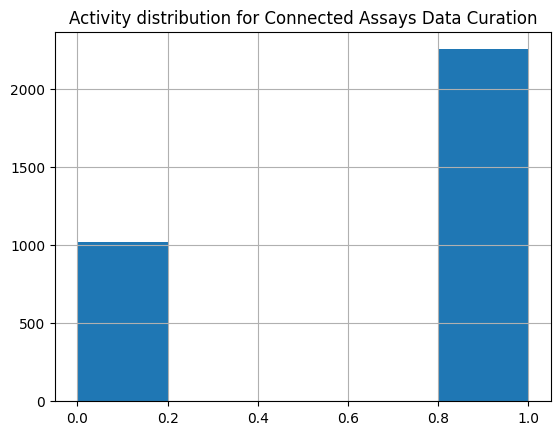

,canonical_Smiles,pIC50,is_phenol,active
0,Brc1ccc(-c2csc(N/N=C/c3cc4ccccc4s3)n2)cc1,4.432974,0,1
1,Brc1ccc(-c2nnn3c2C2c4ccccc4CCN2Cc2ccccc2-3)cc1,7.064241,0,1
2,Brc1ccc(Cn2cc(COc3ccccc3)nn2)cc1,4.274358,0,1
3,Brc1ccc2c(c1)Cc1c-2[nH]c2ccccc12,3.646630,0,0
4,C(=N/Nc1nc(-c2ccccc2)cs1)\c1cccs1,4.040315,0,1


In [14]:
#df = df.rename({"pIC50.1": "pIC50"}, axis=1)
activity_threshold = 4 #100 yM as in
print(f"Activity threshold: {activity_threshold}")

#predict activity 1 or 0
df_process['active'] = df_process['pIC50'].apply(lambda pic50: 0 if pic50 < activity_threshold else 1) #using the median as the

print(f"Number of total compounds: ", len(df_process))
print(f"Number of active compounds: ", len(df_process[df_process["active"] == 1]))
print(f"Number of total compounds: ", len(df_process))

binsize = 0.2
bins = np.arange(0, 1.1, binsize)
plt.hist(df_process['active'], bins=bins)
plt.title("Activity distribution for Connected Assays Data Curation")
plt.grid()
plt.show()

df_process.head()

##Minimal data curation
* take maximal datapoints possible

In [15]:
minimal_df = df_dpph[
    (df_dpph['operator'] == '=') |
    ((df_dpph['operator'].isin(['>', '>='])) & (df_dpph['pIC50'] > 4))
].copy()
print(f"Length of dataframe after minimal Datacuration: ", len(minimal_df))


Length of dataframe after minimal Datacuration:  4455


In [16]:
minimal_df_grouped = (
    minimal_df
    .groupby('canonical_Smiles')
    .agg(
        pIC50_mean=('pIC50', 'mean'),
        pIC50_median=('pIC50', 'median'),
        pIC50_var=('pIC50', 'var'),
        is_phenol=('is_phenol', 'first'),  # All duplicates are identical
        n_measurements=('pIC50', 'count')  # Track how many assays contributed
    )
    .reset_index()
)

minimal_df_grouped.head()

,canonical_Smiles,pIC50_mean,pIC50_median,pIC50_var,is_phenol,n_measurements
0,Brc1ccc(-c2csc(N/N=C/c3cc4ccccc4s3)n2)cc1,4.432974,4.432974,NaN,0,1
1,Brc1ccc(-c2nnn3c2C2c4ccccc4CCN2Cc2ccccc2-3)cc1,7.064241,7.064241,NaN,0,1
2,Brc1ccc(Cn2cc(COc3ccccc3)nn2)cc1,4.274358,4.274358,NaN,0,1
3,Brc1ccc2c(c1)Cc1c-2[nH]c2ccccc12,3.646630,3.646630,NaN,0,1
4,C(=N/Nc1nc(-c2ccccc2)cs1)\c1cccs1,4.040315,4.040315,NaN,0,1


##Processing df from minimal data curation



*   analogous to the next section "Processing df from landrum data curation"




In [17]:
# Step 2: Drop rows with missing canonical_Smiles
minimal_df_process = minimal_df_grouped.dropna(subset=["canonical_Smiles"])

# Step 3: Keep only canonical_Smiles and pIC50_median and is_phenol
minimal_df_process = minimal_df_process[["canonical_Smiles", "pIC50_median", "is_phenol"]].copy()

# Step 4: Rename pIC50_median to pIC50 for ML simplicity
minimal_df_process = minimal_df_process.rename(columns={"pIC50_median": "pIC50"})

# Step 5: Drop duplicates based on SMILES
minimal_df_process = minimal_df_process.drop_duplicates(subset="canonical_Smiles", keep="first")

#create is_phenolic
phenol = "cccccc[OH]"
minimal_df_process["is_phenol"] = minimal_df_process.apply(lambda x: is_substruct_in(mol_smiles=x["canonical_Smiles"], substruct_smarts=phenol), axis=1)

# Step 6: Ensure pIC50 is numeric
minimal_df_process["pIC50"] = pd.to_numeric(minimal_df_process["pIC50"], errors="coerce")
minimal_df_process.head()

,canonical_Smiles,pIC50,is_phenol
0,Brc1ccc(-c2csc(N/N=C/c3cc4ccccc4s3)n2)cc1,4.432974,0
1,Brc1ccc(-c2nnn3c2C2c4ccccc4CCN2Cc2ccccc2-3)cc1,7.064241,0
2,Brc1ccc(Cn2cc(COc3ccccc3)nn2)cc1,4.274358,0
3,Brc1ccc2c(c1)Cc1c-2[nH]c2ccccc12,3.646630,0
4,C(=N/Nc1nc(-c2ccccc2)cs1)\c1cccs1,4.040315,0


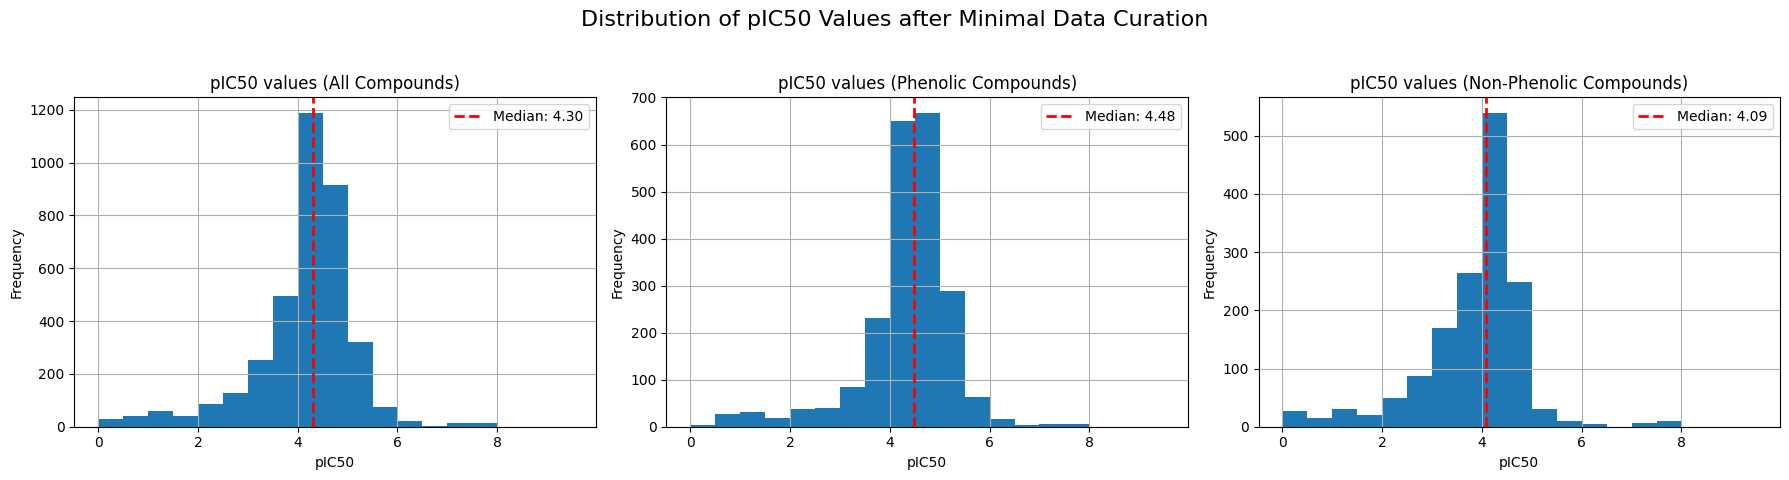

,canonical_Smiles,pIC50,is_phenol
8,C/C(=C/Cc1c([C@@H]2CC(=O)c3c(O)cc(O)cc3O2)ccc(...,4.946960,1
9,C/C(=C/O[C@@H]1O[C@H](COC(=O)c2cc(O)c(O)c(O)c2...,4.502131,1
10,C/C(=C\Cc1cc([C@@H]2CC(=O)c3c(O)cc(O)cc3O2)cc(...,4.691670,1
11,C/C(=C\c1c(C)c(O)cc2c1[nH]c1c(O)ccc(C=O)c12)CC...,5.148742,1
12,C/C(=C\c1c(C)c(O)cc2c1[nH]c1c(O)ccc(CO)c12)CCC...,5.004365,1
...,...,...,...
3675,[O-][S+](/C=C/c1ccc(O)c(O)c1)CCCc1ccccc1,4.841638,1
3676,[O-][S+](/C=C/c1ccc(O)c(O)c1)CCc1ccccc1,4.935542,1
3677,[O-][S+](/C=C/c1ccc(O)c(O)c1)Cc1ccc(C(F)(F)F)cc1,5.107905,1
3678,[O-][S+](/C=C/c1ccc(O)c(O)c1)Cc1ccc(Cl)cc1,5.091515,1


In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot for all compounds
median_all = minimal_df_process["pIC50"].median()
binsize = 0.5
bins = np.arange(0, 10, binsize)
axes[0].hist(minimal_df_process['pIC50'], bins=bins)
axes[0].axvline(x = median_all, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median_all:.2f}")
axes[0].set_xlabel("pIC50")
axes[0].set_ylabel("Frequency")
axes[0].set_title("pIC50 values (All Compounds)")
axes[0].legend()
axes[0].grid()

# Plot for phenolic compounds
df_is_phenol = minimal_df_process[minimal_df_process["is_phenol"] == 1]
median_phenol = df_is_phenol["pIC50"].median()
axes[1].hist(df_is_phenol["pIC50"], bins=bins)
axes[1].axvline(x = median_phenol, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median_phenol:.2f}")
axes[1].set_xlabel("pIC50")
axes[1].set_ylabel("Frequency")
axes[1].set_title("pIC50 values (Phenolic Compounds)")
axes[1].legend()
axes[1].grid()

# Plot for non-phenolic compounds
df_is_not_phenol = minimal_df_process[minimal_df_process["is_phenol"] == 0]
median_not_phenol = df_is_not_phenol["pIC50"].median()
axes[2].hist(df_is_not_phenol["pIC50"], bins=bins)
axes[2].axvline(x = median_not_phenol, color = 'red', linestyle = '--', linewidth = 2, label = f"Median: {median_not_phenol:.2f}")
axes[2].set_xlabel("pIC50")
axes[2].set_ylabel("Frequency")
axes[2].set_title("pIC50 values (Non-Phenolic Compounds)")
axes[2].legend()
axes[2].grid()

# Add a main title to the figure (optional)
fig.suptitle('Distribution of pIC50 Values after Minimal Data Curation', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent titles overlapping
plt.show()

df_is_phenol

Activity threshold: 4
Number of total compounds:  3695
Number of active compounds:  2551
Number of total compounds:  3695


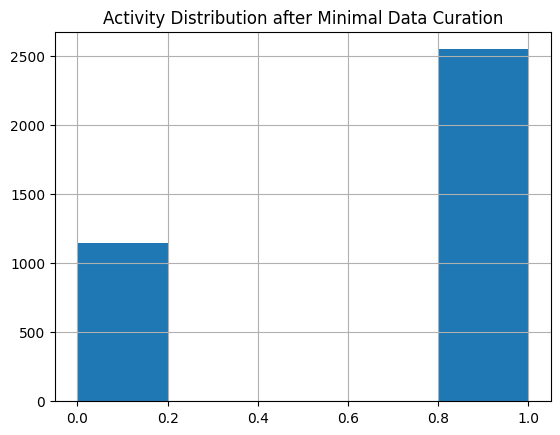

                                 canonical_Smiles     pIC50  is_phenol  active
0       Brc1ccc(-c2csc(N/N=C/c3cc4ccccc4s3)n2)cc1  4.432974          0       1
1  Brc1ccc(-c2nnn3c2C2c4ccccc4CCN2Cc2ccccc2-3)cc1  7.064241          0       1
2                Brc1ccc(Cn2cc(COc3ccccc3)nn2)cc1  4.274358          0       1
3                Brc1ccc2c(c1)Cc1c-2[nH]c2ccccc12  3.646630          0       0
4               C(=N/Nc1nc(-c2ccccc2)cs1)\c1cccs1  4.040315          0       1


In [19]:
activity_threshold = 4 #100 yM as in
print(f"Activity threshold: {activity_threshold}")

#predict activity 1 or 0
minimal_df_process['active'] = minimal_df_process['pIC50'].apply(lambda pic50: 0 if pic50 < activity_threshold else 1) #using the median as the

print(f"Number of total compounds: ", len(minimal_df_process))
print(f"Number of active compounds: ", len(minimal_df_process[minimal_df_process["active"] == 1]))
print(f"Number of total compounds: ", len(minimal_df_process))

binsize = 0.2
bins = np.arange(0, 1.1, binsize)
plt.hist(minimal_df_process['active'], bins=bins)
plt.title("Activity Distribution after Minimal Data Curation")
plt.grid()
plt.show()

print(minimal_df_process.head())


#Train-Test Splits

In [21]:
def process_data(Landrum, Phenol, df_process, minimal_df_process):
    """
    Processes the dataframe based on the Landrum and Phenol switches
    and saves the train and test sets.

    Args:
        Landrum (bool): If True, use the Landrum curated data (df_process).
                        If False, use the Minimal curated data (minimal_df_process).
        Phenol (bool): If True, filter for phenolic compounds.
                       If False, use all compounds.
        df_process (pd.DataFrame): The dataframe processed by the Landrum method.
        minimal_df_process (pd.DataFrame): The dataframe processed by the Minimal method.
    """
    if Landrum:
        df = df_process

        if Phenol and "is_phenol" in df.columns:
            df = df[df["is_phenol"] == 1].copy()

        X = df["canonical_Smiles"]
        y = df["active"]

    else:
        df = minimal_df_process

        if Phenol and "is_phenol" in df.columns:
            df = df[df["is_phenol"] == 1].copy()

        X = df["canonical_Smiles"]
        y = df["active"]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42)

    # === Save the train and test sets (with headers) ===
    prefix = []
    prefix.append("Landrum" if Landrum else "Minimal")
    prefix.append("Phenol" if Phenol else "All")
    basename = "_".join(prefix)

    Train_combined = pd.concat([X_train, y_train], axis=1)
    Train_combined.to_csv(f"{basename}_training_data.csv", index=False)

    Test_combined = pd.concat([X_test, y_test], axis=1)
    Test_combined.to_csv(f"{basename}_test_data.csv", index=False)

# Create all possible combinations of Landrum and Phenol
for Landrum_switch in [True, False]:
    for Phenol_switch in [True, False]:
        print(f"Processing with Landrum={Landrum_switch}, Phenol={Phenol_switch}")
        process_data(Landrum_switch, Phenol_switch, df_process, minimal_df_process)
        print("-" * 20)

Processing with Landrum=True, Phenol=True
--------------------
Processing with Landrum=True, Phenol=False
--------------------
Processing with Landrum=False, Phenol=True
--------------------
Processing with Landrum=False, Phenol=False
--------------------
